# Broadband bi-level taper polarization rotator-splitter

**This notebook contains large simulations. Running the entire notebook will cost about 30 FlexCredits.**

A polarization splitter-rotator (PSR) is a key component in silicon photonics that is used to manage the polarization state of light. It is a critical component in silicon photonic integrated circuits, enabling more complex and versatile photonic devices and systems. As the name suggests, the PSR has two main functions:

**Splitting**: It separates incoming light into its TE and TM components. This is useful because it allows each polarization to be processed separately, which can be important for certain applications.

**Rotating**: It can convert light from one polarization to another. For example, it can convert TE-polarized light to TM-polarized light, or vice versa. This is important because it allows the light to be correctly interfaced with other devices that might require a specific polarization.

In another case study, we have introduced a [compact PSR](../notebooks/PolarizationSplitterRotator.html), which has a small footprint but narrow bandwidth. In the present study, we delve into the exploration of a broadband PSR. This device employs a bi-level taper to transition the TM0 mode input light into the TE1 mode. Subsequently, a long adiabatic coupler transforms this TE1 mode into the TE0 mode. Conversely, the TE0 input light primarily passes through the PSR with minimal alterations. The broadband PSR demonstrates superior bandwidth and insertion loss compared to the compact design, marking a significant improvement. However, it's worth noting that this enhanced performance comes with a trade-off in terms of size. The broadband PSR has a considerably larger footprint, with a length longer than **0.5 mm**, which causes a difficult simulation in conventional numerical tools. For Tidy3D, even such a large 3D full-wave simulation is fast.

The design is based on `Wesley D. Sacher, Tymon Barwicz, Benjamin J. F. Taylor, and Joyce K. S. Poon, "Polarization rotator-splitters in standard active silicon photonics platforms," Opt. Express 22, 3777-3786 (2014)`, [DOI: 10.1364/OE.22.003777](https://doi.org/10.1364/OE.22.003777).

<img src="img/bilevel_PSR.png" width="500" alt="Schematic of the PSR">

For more integrated photonic examples such as the [8-Channel mode and polarization de-multiplexer](https://www.flexcompute.com/tidy3d/examples/notebooks/8ChannelDemultiplexer/), the [90 degree optical hybrid](https://www.flexcompute.com/tidy3d/examples/notebooks/90OpticalHybrid/), and the [broadband directional coupler](https://www.flexcompute.com/tidy3d/examples/notebooks/BroadbandDirectionalCoupler/), please visit our [examples page](https://www.flexcompute.com/tidy3d/examples/). If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. FDTD simulations can diverge due to various reasons. If you run into any simulation divergence issues, please follow the steps outlined in our [troubleshooting guide](https://www.flexcompute.com/tidy3d/examples/notebooks/DivergedFDTDSimulation/) to resolve it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gdstk

import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.mode import ModeSolver

## Simulation Setup

The simulation wavelength range is from 1500 nm to 1580 nm.

In [2]:
lda0 = 1.54  # central wavelength
ldas = np.linspace(1.5, 1.58, 101)  # wavelength range of interest
freq0 = td.C_0 / lda0  # central frequency
freqs = td.C_0 / ldas  # frequency range of interest
fwidth = 0.4 * (np.max(freqs) - np.min(freqs))  # frequency width of the source

In this wavelength range, silicon and silicon oxide have minimal dispersion. Therefore, we use a constant refractive index for both. 

In [3]:
# define silicon and silicon dioxide media from material library
si = td.Medium(permittivity=3.47**2)
sio2 = td.Medium(permittivity=1.44**2)

Define geometric parameters. The parameters are indicated in the figure below. In addition, we add a side wall angle to mimic realistic fabrication and see if this will degrade the device performance. 

<img src="img/bilevel_PSR_2.png" width="500" alt="Top view of the PSR">

In [4]:
L_blt = 100  # length of the bi-level taper
L_ac = 300  # length of the adiabatic coupler
L_s = 5  # length of the straight waveguide between the bi-level taper and the adiabatic coupler
L_t = 30  # length of the top waveguide taper after the adiabatic coupler

w_1 = 0.45  # input waveguide width
w_2 = 0.55  # waveguide width at the center of the bi-level taper
w_pes = 1.55  # width of the widest part of the partially etched slab
w_3 = 0.85  # waveguide width at the output of the bi-level taper
w_4 = 0.2  # waveguide width at the beginning of the bottom waveguide
w_5 = 0.65  # top waveguide width at the end of the adiabatic coupler
w_6 = 0.5  # output waveguide width
gap = 0.2  # gap size of the adiabatic coupler

t_pes = 0.09  # thickness of the partially etched slab
t_si = 0.22  # thickness of the silicon layer

inf_eff = 1e5  # effective infinity

sidewall_angle = 10 * np.pi / 180  # side wall angle

Define the partially etched slab structure.

In [5]:
# define the partially etched slab
vertices = [
    (0, w_1 / 2),
    (L_blt / 2, w_pes / 2),
    (L_blt, w_3 / 2),
    (L_blt, -w_3 / 2),
    (L_blt / 2, -w_pes / 2),
    (0, -w_1 / 2),
]

partially_etched_slab = td.Structure(
    geometry=td.PolySlab(
        vertices=vertices,
        axis=2,
        slab_bounds=(0, t_pes),
        sidewall_angle=sidewall_angle,
    ),
    medium=si,
)

Define the waveguide structures using `gdstk`. For structures with bending parts, using `gdstk` is easy and convenient.

In [6]:
R = 300  # bend radius
theta = np.pi / 30  # s bend angle

# define a gds cell
cell = gdstk.Cell("device") 

# define the top waveguide using a path
top_wg = gdstk.RobustPath((-inf_eff, 0), w_1,layer=1, datatype=0)
top_wg.horizontal(0)
top_wg.horizontal(L_blt / 2, w_2)
top_wg.horizontal(L_blt, w_3)
top_wg.horizontal(L_blt + L_s)
top_wg.segment((L_blt + L_s + L_ac, (w_5-w_3)/2), w_5)
top_wg.horizontal(L_blt + L_s + L_ac + L_t)
top_wg.arc(R, -np.pi / 2, -np.pi / 2 + theta)
top_wg.arc(R, np.pi / 2 + theta, np.pi / 2)
top_wg.horizontal(inf_eff)
cell.add(top_wg)

# define the bottom waveguide using a path
bottom_wg = gdstk.RobustPath((L_blt + L_s, (-w_4-w_3-2*gap)/2), w_4, layer=1, datatype=0)
bottom_wg.segment((L_blt + L_s + L_ac, (-w_3-2*gap-w_6)/2), w_6)
bottom_wg.arc(R, np.pi / 2, np.pi / 2 - theta)
bottom_wg.arc(R, -np.pi / 2 - theta, -np.pi / 2)
bottom_wg.horizontal(inf_eff)
cell.add(bottom_wg)   

# define the waveguide tidy3d geometries
wg_geos = td.PolySlab.from_gds(
    cell,
    gds_layer=1,
    axis=2,
    slab_bounds=(0, t_si),
    sidewall_angle=sidewall_angle,
)

# define the waveguide tidy3d structures
wgs = [td.Structure(geometry=wg_geo, medium=si) for wg_geo in wg_geos]

Define source, monitors, and simulation. Here we will define a [ModeSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeSource.html) that launches the TE0 mode into the input waveguide. Two [ModeMonitors](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeMonitor.html) are added to the top and bottom waveguides to monitor the transmission. A [FieldMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldMonitor.html) is added in the $xy$ plane to visualize the field distribution.

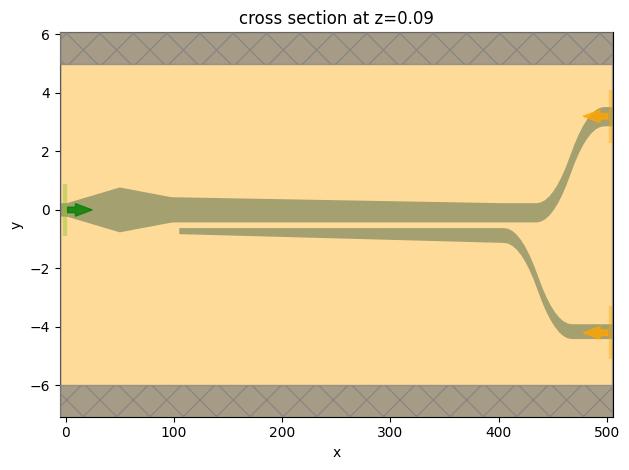

In [7]:
run_time = 15e-12  # simulation run time

Lx = 510  # simulation domain size in x
Ly = 11  # simulation domain size in y
Lz = 9 * t_si  # simulation domain size in z

x0 = 250  # simulation domain center in x
y0 = -0.5  # simulation domain center in y
z0 = t_si / 2  # simulation domain center in z

# define a mode source that launches the TE0 mode
mode_spec = td.ModeSpec(num_modes=2, target_neff=3.47)
mode_source_te = td.ModeSource(
    center=(-lda0 / 2, 0, t_si / 2),
    size=(0, 4 * w_1, 6 * t_si),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
)

# define a mode monitor at the top waveguide output
mode_monitor_top = td.ModeMonitor(
    center=(x0 + Lx / 2 - lda0, 3.2, t_si / 2),
    size=mode_source_te.size,
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode_top",
)

# define a mode monitor at the bottom waveguide output
mode_monitor_bottom = td.ModeMonitor(
    center=(x0 + Lx / 2 - lda0, -4.2, t_si / 2),
    size=mode_source_te.size,
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode_bottom",
)

# define a field monitor to visualize field intensity distribution in the xy plane
field_monitor = td.FieldMonitor(
    center=(0, 0, t_pes),
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    interval_space=(2, 2, 1),
    name="field",
)

# define simulation
sim_te = td.Simulation(
    center=(x0, y0, z0),
    size=(Lx, Ly, Lz),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=12, wavelength=lda0),
    structures=[partially_etched_slab] + wgs,
    sources=[mode_source_te],
    monitors=[mode_monitor_top, mode_monitor_bottom, field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    medium=sio2,
)

# visualize the simulation
ax = sim_te.plot(z=t_pes)
ax.set_aspect("auto")

We can also visualize the cross sections at different $x$ positions of the bi-level taper.

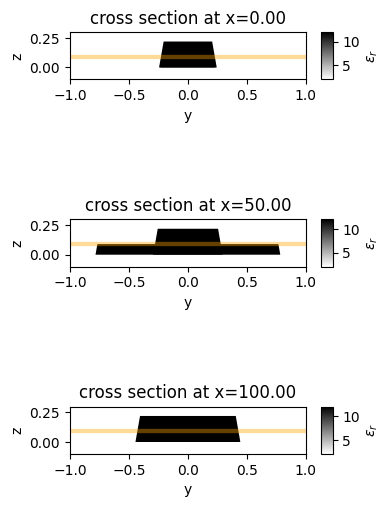

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(4, 7), tight_layout=True)

for i in range(3):
    sim_te.plot_eps(x=i * L_blt / 2, freq=freq0, ax=ax[i])
    ax[i].set_xlim(-1, 1)
    ax[i].set_ylim(-0.1, 0.3)

## Mode Analysis 

We can intuitively visualize the mode evolution alone the device to see physically why it functions as a PSR. This requires us to perform mode analysis at different $x$ positions. First, let's perform the mode analysis at the input waveguide ($x=0$) and solve for two modes. 

As expected, the first mode is TE0 mode and the second mode is the TM0 mode. Note that the grid looks a bit coarse. If a finer resolution for the mode profile is needed, either use a finer grid or use Tidy3D's [waveguide plugin](https://www.flexcompute.com/tidy3d/examples/notebooks/WaveguidePluginDemonstration/) for the same analysis. 

11:08:29 UTC WARNING: Use the remote mode solver with subpixel averaging for    
             better accuracy through 'tidy3d.plugins.mode.web.run(...)'.        

wavelength     n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                  
1.946704e+14 0                 1.54  2.386117    0.0          0.975661   
             1                 1.54  1.758549    0.0          0.046269   

                         wg TE fraction  wg TM fraction  mode area  
f            mode_index                                             
1.946704e+14 0                 0.729618        0.821577   0.194031  
             1                 0.699665        0.880205   0.355355

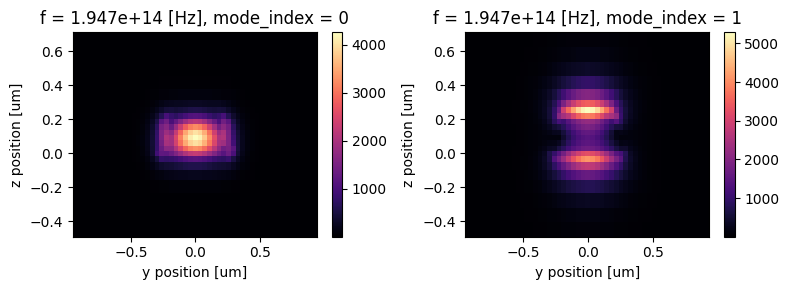

In [9]:
mode_solver = ModeSolver(
    simulation=sim_te,
    plane=td.Box(center=(0, 0, t_si/2), size=(0, 4*w_1, 5*t_si)),
    mode_spec=mode_spec,
    freqs=[freq0],
)
mode_data = mode_solver.solve()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3), tight_layout=True)
mode_data.intensity.sel(mode_index=0).plot(x='y', y='z', cmap='magma', ax=ax1)
mode_data.intensity.sel(mode_index=1).plot(x='y', y='z', cmap='magma', ax=ax2)

mode_data.to_dataframe()

Similarly, we move the mode analysis plane to the bi-level taper section at $x=L_{blt}/2$. The first mode is still the TE0 while the second mode becomes a hybrid mode due to the fact that the partially etched slab breaks the vertical mirror symmetry.

wavelength     n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                  
1.946704e+14 0                 1.54  2.623751    0.0          0.992292   
             1                 1.54  2.140927    0.0          0.905734   

                         wg TE fraction  wg TM fraction  mode area  
f            mode_index                                             
1.946704e+14 0                 0.884681        0.807455   0.197804  
             1                 0.821026        0.802903   0.385694

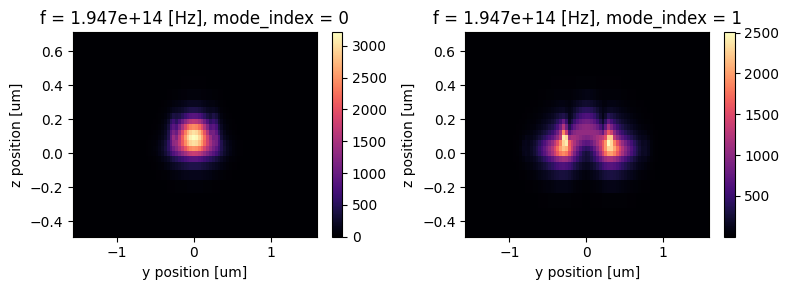

In [10]:
mode_solver = mode_solver.copy(update={"plane": td.Box(center=(L_blt/2, 0, t_si/2), size=(0, 2*w_pes, 5*t_si))})
mode_data = mode_solver.solve()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3), tight_layout=True)
mode_data.intensity.sel(mode_index=0).plot(x='y', y='z', cmap='magma', ax=ax1)
mode_data.intensity.sel(mode_index=1).plot(x='y', y='z', cmap='magma', ax=ax2)

mode_data.to_dataframe()

The same mode analysis at the end of the bi-level taper section shows the first mode as the TE0 and the second mode as the TE1. That is, when TM0 mode is launched at the input waveguide, it adiabatically converts into the TE1 mode.

wavelength     n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                  
1.946704e+14 0                 1.54  2.724055    0.0          0.997053   
             1                 1.54  2.284869    0.0          0.977161   

                         wg TE fraction  wg TM fraction  mode area  
f            mode_index                                             
1.946704e+14 0                 0.906866        0.810590   0.209982  
             1                 0.673375        0.848376   0.330191

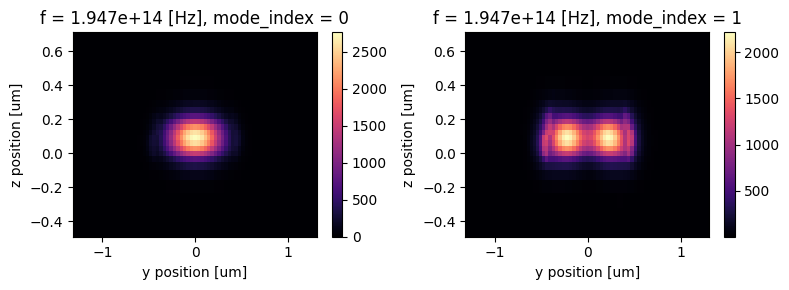

In [11]:
mode_solver = mode_solver.copy(update={"plane": td.Box(center=(L_blt + L_s, 0, t_si/2), size=(0, 3*w_3, 5*t_si))})
mode_data = mode_solver.solve()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3), tight_layout=True)
mode_data.intensity.sel(mode_index=0).plot(x='y', y='z', cmap='magma', ax=ax1)
mode_data.intensity.sel(mode_index=1).plot(x='y', y='z', cmap='magma', ax=ax2)

mode_data.to_dataframe()

Lastly, mode analysis at the end of the adiabatic coupler section shows the first mode as the TE0 at the top waveguide and the second mode as the TE0 at the bottom waveguide, which indicates that with an appropriate choice of coupling length and gap size, the TE1 mode on the top waveguide will be converted into the TE0 mode at the bottom waveguide. The TE0 mode launched in the input waveguide however stays as TE0 throughout the device. 

For a more detailed analysis, please refer to the [reference](https://doi.org/10.1364/OE.22.003777). 

wavelength     n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                  
1.946704e+14 0                 1.54  2.629170    0.0          0.992861   
             1                 1.54  2.477717    0.0          0.983444   

                         wg TE fraction  wg TM fraction  mode area  
f            mode_index                                             
1.946704e+14 0                 0.850426        0.815152   0.189568  
             1                 0.772801        0.820322   0.188611

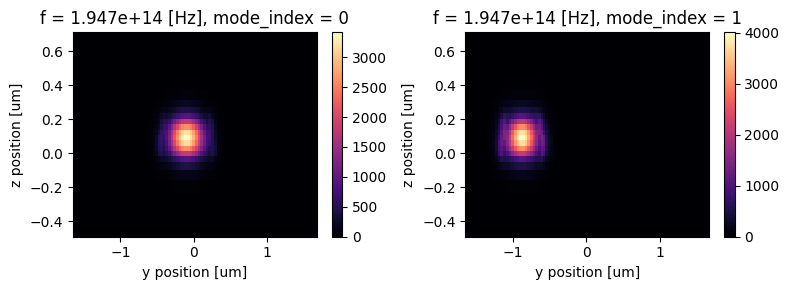

In [12]:
mode_solver = mode_solver.copy(update={"plane": td.Box(center=(L_blt + L_s + L_ac, 0, t_si/2), size=(0, 5*w_5, 5*t_si))})
mode_data = mode_solver.solve()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3), tight_layout=True)
mode_data.intensity.sel(mode_index=0).plot(x='y', y='z', cmap='magma', ax=ax1)
mode_data.intensity.sel(mode_index=1).plot(x='y', y='z', cmap='magma', ax=ax2)

mode_data.to_dataframe()

## Run a Batch Simulation 

We also want to investigate the TM mode as input. To do so, we only need to define a new [ModeSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeSource.html) and set `mode_index=1`. Then a simulation is created by copying the previous simulation with the sources updated. To run both the TE and TM input simulations simultaneously, we made a simulation batch. 

In [13]:
# define a new mode source that launches the tm mode
mode_source_tm = mode_source_te.copy(update={"mode_index": 1})

# define a new simulation and update the source
sim_tm = sim_te.copy(update={"sources": [mode_source_tm]})

# define a simulation batch
sims = {
    "TE input": sim_te,
    "TM input": sim_tm,
}
batch = web.Batch(simulations=sims)

Submit the simulation batch to the server.

In [14]:
batch_results = batch.run(path_dir="data")

Output()

11:08:36 UTC Started working on Batch containing 2 tasks.

11:08:38 UTC Maximum FlexCredit cost: 27.381 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

## Result Analysis

We define a helper function to plot the transmission spectra of the TE and TM modes at the top and bottom output waveguides.

In [15]:
def plot_transmission(sim_data):

    # get te mode amplitude in the top waveguide
    amp_top_te = sim_data["mode_top"].amps.sel(mode_index=0, direction="+")
    # calculate te mode transmission in the top waveguide
    T_top_te = np.abs(amp_top_te) ** 2
    # get tm mode amplitude in the top waveguide
    amp_top_tm = sim_data["mode_top"].amps.sel(mode_index=1, direction="+")
    # calculate tm mode transmission in the top waveguide
    T_top_tm = np.abs(amp_top_tm) ** 2
    # get te mode amplitude in the bottom waveguide
    amp_bottom_te = sim_data["mode_bottom"].amps.sel(mode_index=0, direction="+")
    # calculate te mode transmission in the bottom waveguide
    T_bottom_te = np.abs(amp_bottom_te) ** 2
    # get tm mode amplitude in the bottom waveguide
    amp_bottom_tm = sim_data["mode_bottom"].amps.sel(mode_index=1, direction="+")
    # calculate tm mode transmission in the bottom waveguide
    T_bottom_tm = np.abs(amp_bottom_tm) ** 2

    # plotting transmission spectra in dB
    plt.plot(ldas, 10 * np.log10(T_top_te), label="Top TE")
    plt.plot(ldas, 10 * np.log10(T_top_tm), label="Top TM")
    plt.plot(ldas, 10 * np.log10(T_bottom_te), label="Bottom TE")
    plt.plot(ldas, 10 * np.log10(T_bottom_tm), label="Bottom TM")

    # formatting the plot
    plt.xlim(1.5, 1.58)
    plt.ylim(-60, 1)
    plt.xlabel("Wavelength ($\mu m$)")
    plt.ylabel("Transmission (dB)")
    plt.legend()
    plt.show()

Plot the transmission spectra for the TE input case. From the transmission plot, we can see that when the input mode is TE, all power is transmitted to the TE mode in the top waveguide.

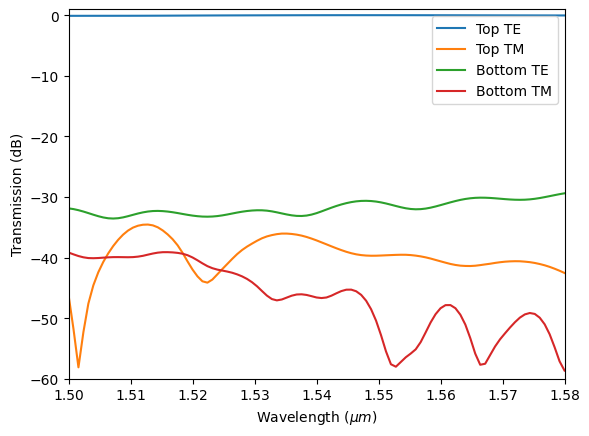

In [16]:
sim_data_te = batch_results["TE input"]
plot_transmission(sim_data_te)

Plot the field intensity distribution.

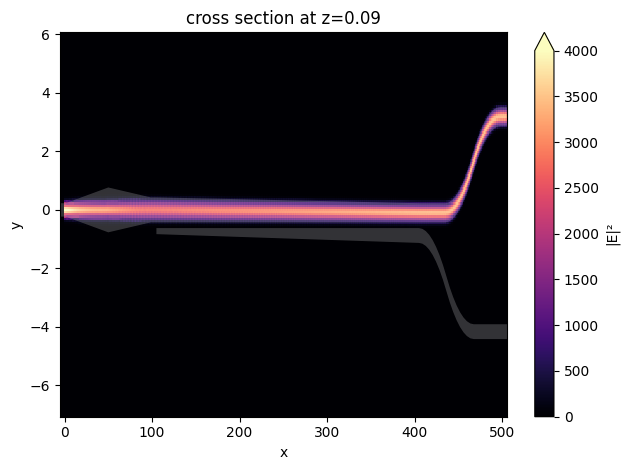

In [17]:
ax = sim_data_te.plot_field(
    field_monitor_name="field", field_name="E", val="abs^2", vmin=0, vmax=4e3
)
ax.set_aspect("auto")

Plot the transmission spectra for the TM input case. From the transmission plot, we can see that when the input mode is TM, all power is transmitted to the TE mode in the bottom waveguide.

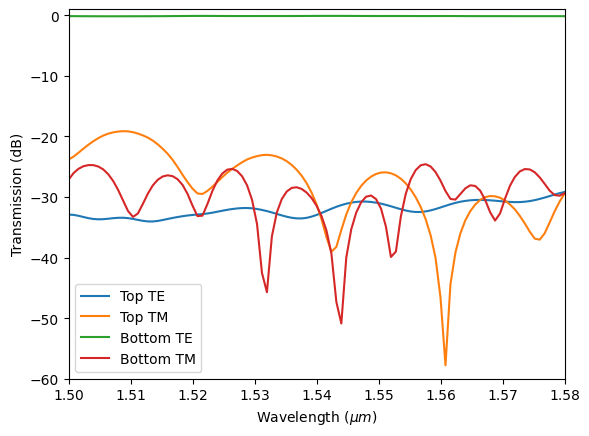

In [18]:
sim_data_tm = batch_results["TM input"]
plot_transmission(sim_data_tm)

Plot the field intensity distribution as before.

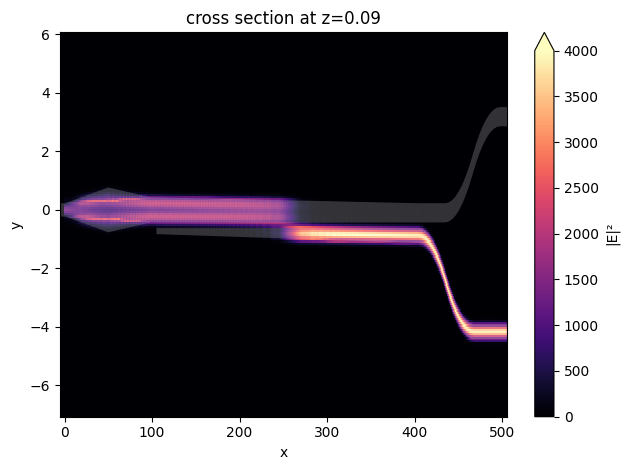

In [19]:
ax = sim_data_tm.plot_field(
    field_monitor_name="field", field_name="E", val="abs^2", vmin=0, vmax=4e3
)
ax.set_aspect("auto")

In conclusion, we see that the device functions as a PSR. The TE0 input is transmitted to the top waveguide at the output while staying as the TE0. The TM0 input is rotated to TE0 and transmitted to the bottom waveguide at the output. The loss is small in both cases. 